In [29]:
import pandas as pd 
import numpy as np
import openmatrix as omx
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# ActivitySim Data 
hdf = pd.HDFStore('../output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  2605386
Number of Persons:  6802651
Number of tours:  9209614
Number of trips:  23238928


## Distribution of Work-trip distances

Source: LODES

In [85]:
# Read LODES files
file_path = 'ca_od_main_JT00_2010.csv.gz'
lodes = pd.read_csv(file_path, dtype={'w_geocode': str, 'h_geocode': str},
                    usecols=['w_geocode', 'h_geocode', 'S000']) # 'S000' total number of jobs

# Read blocks to TAZ map
blocks = pd.read_csv('geoid_to_zone.csv', dtype={'GEOID': str,})

# Read Skims (to get TAZ-to-TAZ distance)
skims = omx.open_file('../data/skims.omx', mode = 'r')

In [86]:
# Prepare LODES data:

#Filter home and work block_ids in Bay Area only  
bayarea_home_filter = lodes.h_geocode.isin(blocks.GEOID)
bayarea_work_filter = lodes.w_geocode.isin(blocks.GEOID)
workers_lodes = lodes[(bayarea_home_filter) & (bayarea_work_filter)]

# Match block_id with TAZ for home and work location 
workers_lodes = workers_lodes.merge(blocks, 
                                    how = 'left',
                                    left_on = 'h_geocode',
                                    right_on = 'GEOID').merge(
                                    blocks, how = 'left',
                                    left_on = 'w_geocode',
                                    right_on = 'GEOID',
                                    suffixes= ['_home', '_workplace'])

# Query HOME-WORK distance 
dist = np.array(skims['DIST'])
workers_lodes['dist'] = dist[workers_lodes.zone_id_home.astype(int) - 1,
                             workers_lodes.zone_id_workplace.astype(int) - 1]

# Adjust observations by weights
observations = workers_lodes['dist']
weights = workers_lodes['S000']

# Calculate cumulative sum of weights
cumulative_weights = np.cumsum(weights)

# Duplicate observations based on weights
duplicated_observations = pd.DataFrame(np.repeat(observations, weights))

In [87]:
# ActivitySim
cols = ['home_taz', 'workplace_taz', 'distance_to_work']
asim_workers = pp[pp.worker == 1][cols]

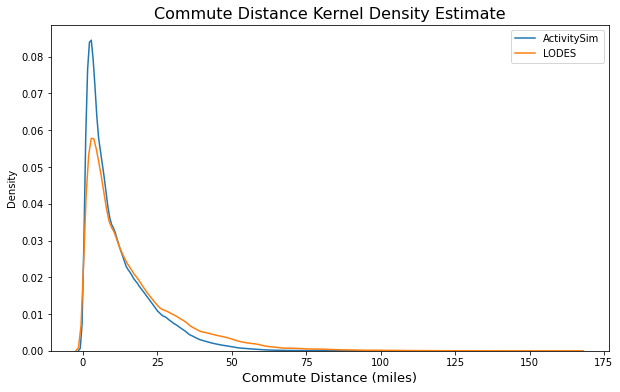

In [88]:
# Plot 
fig, ax = plt.subplots(figsize=(10,6))

# Plot ActivitySim commute distances 
sns.kdeplot(asim_workers['distance_to_work'], ax=ax, label='ActivitySim')

# Plot LODES commute distances 
sns.kdeplot(duplicated_observations['dist'], ax=ax, label='LODES')

#Set x-label
ax.set_xlabel('Commute Distance (miles)', fontsize=13)

#Set figure title 
plt.title('Commute Distance Kernel Density Estimate', fontsize=16)

#Add legend 
plt.legend()


plt.show()

## Commute Mode Choice
Data Source: U.S. Census Bureau, American Community Survey 2012-2016 Five-year estimates. Special Tabulation: Census Transportation Planning (CTPP)

In [209]:
# CTPP Data 
file_name = 'CTPP - A302103 - Means of transportation (18) (Workers 16 years and over).csv'
ctpp_ms = pd.read_csv(file_name)

In [210]:
modes_ctpp = {'Car, truck, or van -- Drove alone': 'Car',
         'Car, truck, or van -- In a 2-person carpool': 'Car',
         'Car, truck, or van -- In a 3-person carpool': 'Car',
         'Car, truck, or van -- In a 4-person carpool': 'Car',
         'Car, truck, or van -- In a 5-or-6-person carpool': 'Car',
         'Car, truck, or van -- In a 7-or-more-person carpool': 'Car',
         'Bus or trolley bus': 'Transit-Bus', 
         'Streetcar or trolley car': 'Transit-Bus',
         'Subway or elevated': 'Transit-Rail', 
         'Railroad' : 'Transit-Rail', 
         'Ferryboat': 'Transit-Bus', 
         'Bicycle': 'Bike', 
         'Walked': 'Walk',
         'Taxicab': 'TNC',
         'Motorcycle': 'other',
         'Other method':'other', 
         'Auto': np.nan, 
         'Total, means of transportation': np.nan,
         'Worked at home':np.nan}

ctpp_ms['ctpp_mode'] = ctpp_ms['Means of Transportation 18'].replace(modes_ctpp)

# Drop Summary Totals 
ctpp_ms.dropna(subset = ['ctpp_mode'], inplace = True)

# Remove commas and convert to integers
ctpp_ms['workers'] = ctpp_ms['Workers 16 and Over'].str.replace(',', '').astype(int)

# Estimate Filter (remove marging)
estimate_filter = ctpp_ms.Output == 'Estimate'
ctpp_ms = ctpp_ms[estimate_filter]

#Sum county to county estimate
ctpp_ms = ctpp_ms.groupby('ctpp_mode').agg({'workers':'sum'})
# ctpp_ms = ctpp_mss[~ctpp_ms.index.isin(['Worked at home'])]
ctpp_ms = 100 * (ctpp_ms/ctpp_ms.sum())
ctpp_ms

,workers
ctpp_mode,
Bike,1.924877
Car,80.447405
TNC,0.157970
Transit-Bus,6.491598
Transit-Rail,5.819102
Walk,3.828572
other,1.330477


In [211]:
modes_asim = {'WALK_LRF': 'Transit-Rail', 
              'WALK_LOC': 'Transit-Bus', 
              'SHARED3FREE': 'Car', 
              'WALK_COM': 'Transit-Bus',
              'DRIVEALONEFREE': 'Car', 
              'SHARED2FREE':'Car', 
              'BIKE': 'Bike', 
              'DRIVE_LRF': 'Transit-Rail',
              'WALK': 'Walk',
              'WALK_HVY':'Transit-Rail', 
              'WALK_EXP':'Transit-Bus', 
              'DRIVE_LOC': 'Transit-Bus', 
              'DRIVE_HVY':'Transit-Rail', 
              'DRIVE_COM':'Transit-Bus',
              'DRIVEALONEPAY':'Car', 
              'SHARED2PAY':'Car', 
              'DRIVE_EXP': 'Transit-Bus',
              'SHARED3PAY':'Car', 
              'TNC_SINGLE': 'TNC',
              'TNC_SHARED': 'TNC', 
              'TAXI': 'TNC'}

In [213]:
trips['asim_mode_choice'] = trips.trip_mode.replace(modes_asim)
work_trips = trips.primary_purpose == 'work'
asim_ms = trips[work_trips]['asim_mode_choice'].value_counts(normalize = True) * 100

Text(0, 0.5, 'Share (%)')

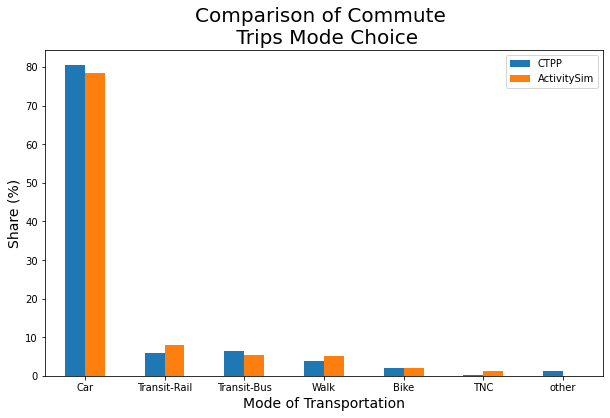

In [230]:
# Pre-process data
df = pd.concat((ctpp_ms, asim_ms), axis = 1)
df = df.sort_values(by = 'asim_mode_choice', ascending = False)
df.columns = ['CTPP', 'ActivitySim']

# Create the bar plot
ax = df.plot.bar(rot=0, figsize=(10, 6))

# Set plot title and labels
ax.set_title('Comparison of Commute \n Trips Mode Choice', fontsize = 20)
ax.set_xlabel('Mode of Transportation', fontsize = 14)
ax.set_ylabel('Share (%)', fontsize = 14)